# GAN and DCGAN task from Lecture
### Transfered to a this directory to keep sanity between the lecture notes and Kaleb's implementation
Task description: "**Task**: Try generating more complex color images with DCGAN - for example, take one class from CIFAR-10 dataset."

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Shared Requirements

In [3]:
batch_size = 16
epochs = 100
plot_every = 10

In [4]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [5]:
# Define the transformations for the training and testing sets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),  # Randomly crop the images
    transforms.RandomHorizontalFlip(),     # Randomly flip the images horizontally
    transforms.ToTensor(),                 # Convert the images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalize the images
])

transform_test = transforms.Compose([
    transforms.ToTensor(),                 # Convert the images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalize the images
])

class SpecificClassDataset(Dataset):
    def __init__(self, dataset, target_class):
        self.dataset = dataset
        self.target_class = target_class
        self.indices = [i for i, (_, label) in enumerate(self.dataset) if label == self.target_class]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        image, label = self.dataset[original_idx]
        return image, label

# Load the CIFAR-10 training dataset
train_dataset_full = torchvision.datasets.CIFAR10(
    root='./data',       # Directory to store the dataset
    train=True,          # Specify that this is the training set
    transform=transform_train,  # Apply the training transformations
    download=True        # Download the dataset if it's not already available
)

# Load the CIFAR-10 test dataset
test_dataset_full = torchvision.datasets.CIFAR10(
    root='./data',       # Directory to store the dataset
    train=False,         # Specify that this is the test set
    transform=transform_test,  # Apply the test transformations
    download=True        # Download the dataset if it's not already available
)

# Specify the class you want to filter
# airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
# 0             1         2    3    4     5    6      7     8      9

target_class = 3

# Create specific class datasets
train_dataset = SpecificClassDataset(train_dataset_full, target_class)
test_dataset = SpecificClassDataset(test_dataset_full, target_class)

# Create data loaders for the training and testing sets
train_loader = DataLoader(
    dataset=train_dataset,  # The training dataset
    batch_size=batch_size,          # Number of samples per batch
    shuffle=True,           # Shuffle the data at every epoch
    num_workers=2           # Number of subprocesses to use for data loading
)

test_loader = DataLoader(
    dataset=test_dataset,   # The test dataset
    batch_size=batch_size,          # Number of samples per batch
    shuffle=False,          # Do not shuffle the data
    num_workers=2           # Number of subprocesses to use for data loading
)

dataloaders = (train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified


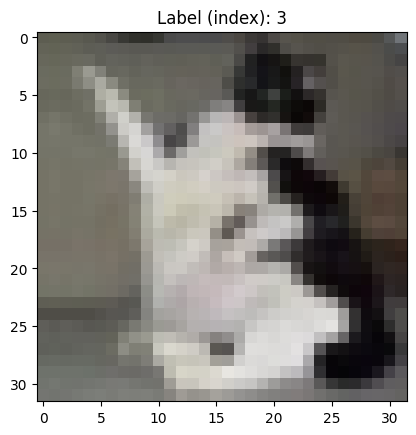

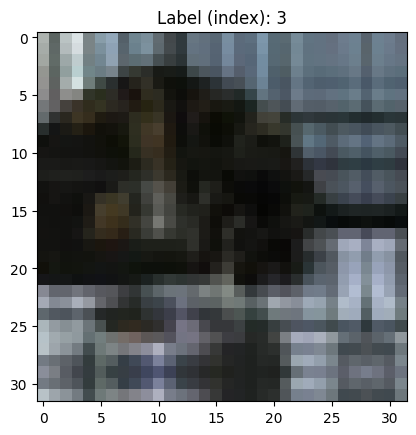

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


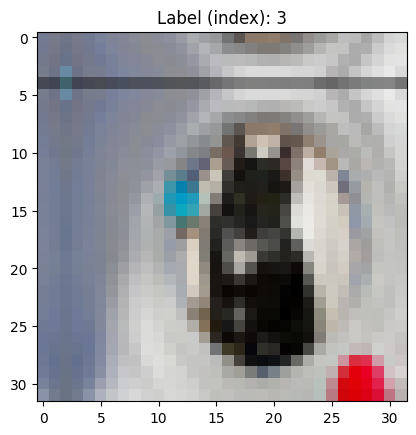

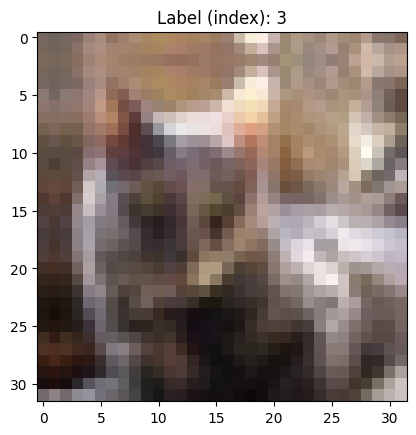

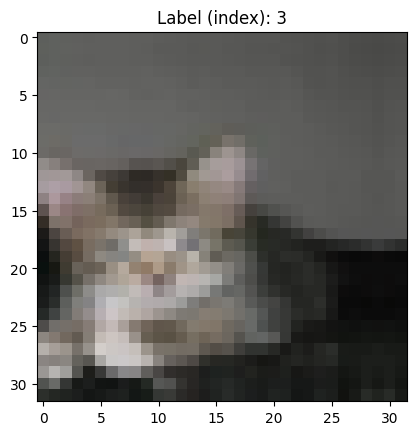

In [6]:
# Function to unnormalize and show an image
def unnormalize(img, mean, std):
    img = img.clone()  # Clone to avoid modifying the original tensor
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Unnormalize
    return img
    
def imshow(img, title):
    unimg = unnormalize(img, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))  # Unnormalize
    npimg = unimg.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print 5 images from the dataset
for i in range(5):
    imshow(images[i], f'Label (index): {labels[i].item()}')

# GAN Implementation

In [7]:
train_size = 1.0
lr = 1e-3
weight_decay = 8e-9
beta1 = 0.5
beta2 = 0.999

In [8]:
def plotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100))).to(device)
    imgs = generator(noise).detach().cpu()
    
    # Rescale from [-1, 1] to [0, 1]
    imgs = (imgs + 1) / 2
    # imgs = torch.clamp(imgs, 0, 1)
    fig, ax = plt.subplots(1, n, figsize=(n * 3, 3))
    for i, im in enumerate(imgs):
        # print(im.shape)
        # print(im[0])
        ax[i].imshow(np.transpose(im.numpy(), (1, 2, 0)))  # Convert from CHW to HWC format
        ax[i].axis('off')
    plt.show()

In [9]:
def train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]
    
    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    for epoch in tqdm_iter:
        gen.train()
        disc.train()

        train_gen_loss = 0.0
        train_disc_loss = 0.0
        
        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)

            disc.eval()
            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)
            
            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.train()
            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            plotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [10]:
class KeiGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256, momentum=0.2)
        self.linear2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512, momentum=0.2)
        self.linear3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024, momentum=0.2)
        self.linear4 = nn.Linear(1024, 2048)
        self.bn4 = nn.BatchNorm1d(2048, momentum=0.2)
        self.linear5 = nn.Linear(2048, 3072)
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, input):
        hidden1 = self.leaky_relu(self.bn1(self.linear1(input)))
        hidden2 = self.leaky_relu(self.bn2(self.linear2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.linear3(hidden2)))
        hidden4 = self.leaky_relu(self.bn4(self.linear4(hidden3)))
        generated = self.tanh(self.linear5(hidden4)).view(input.shape[0], 3, 32, 32)
        return generated

In [11]:
class KeiDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3072, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = input.view(input.shape[0], -1)
        hidden1 = self.leaky_relu(self.linear1(input))
        hidden2 = self.leaky_relu(self.linear2(hidden1))
        hidden3 = self.leaky_relu(self.linear3(hidden2))
        classififed = self.sigmoid(self.linear4(hidden3))
        return classififed

In [12]:
generator = KeiGenerator().to(device)
discriminator = KeiDiscriminator().to(device)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

In [13]:
print(summary(generator,input_size=(1,100)))
print(summary(discriminator,input_size=(1,3,32,32)))

Layer (type:depth-idx)                   Output Shape              Param #
KeiGenerator                             [1, 3, 32, 32]            --
├─Linear: 1-1                            [1, 256]                  25,856
├─BatchNorm1d: 1-2                       [1, 256]                  512
├─LeakyReLU: 1-3                         [1, 256]                  --
├─Linear: 1-4                            [1, 512]                  131,584
├─BatchNorm1d: 1-5                       [1, 512]                  1,024
├─LeakyReLU: 1-6                         [1, 512]                  --
├─Linear: 1-7                            [1, 1024]                 525,312
├─BatchNorm1d: 1-8                       [1, 1024]                 2,048
├─LeakyReLU: 1-9                         [1, 1024]                 --
├─Linear: 1-10                           [1, 2048]                 2,099,200
├─BatchNorm1d: 1-11                      [1, 2048]                 4,096
├─LeakyReLU: 1-12                        [1, 2048]    

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

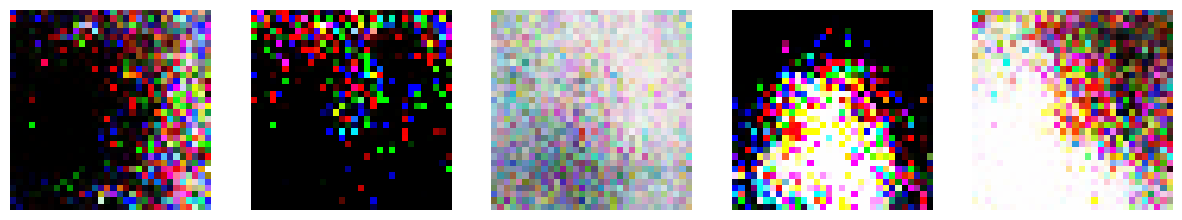

 10%|███▎                             | 10/100 [00:49<07:24,  4.94s/it, generator loss:=1.39, discriminator loss:=0.446]

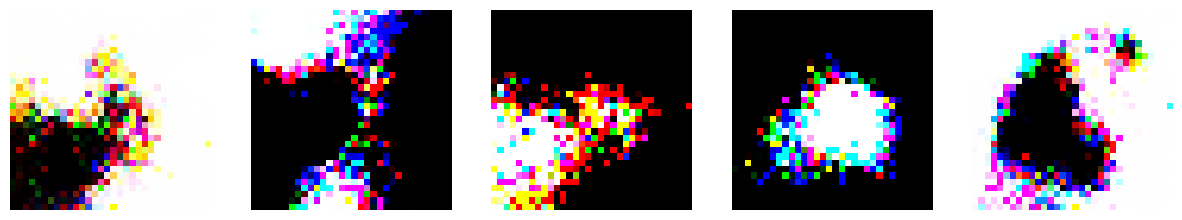

 20%|██████▌                          | 20/100 [01:38<06:28,  4.86s/it, generator loss:=1.89, discriminator loss:=0.365]

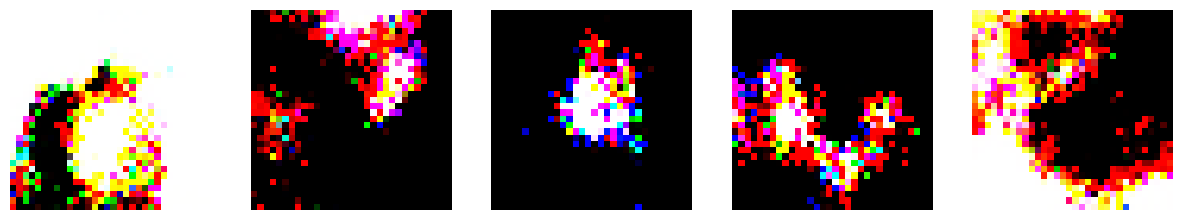

 30%|██████████▏                       | 30/100 [02:28<05:47,  4.96s/it, generator loss:=2.3, discriminator loss:=0.298]

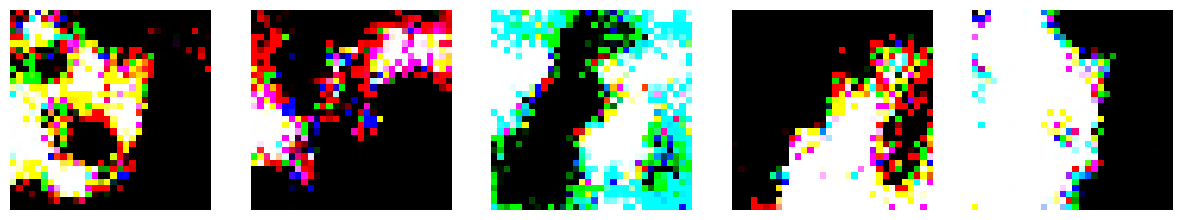

 40%|█████████████▌                    | 40/100 [03:18<04:55,  4.92s/it, generator loss:=2.63, discriminator loss:=0.26]

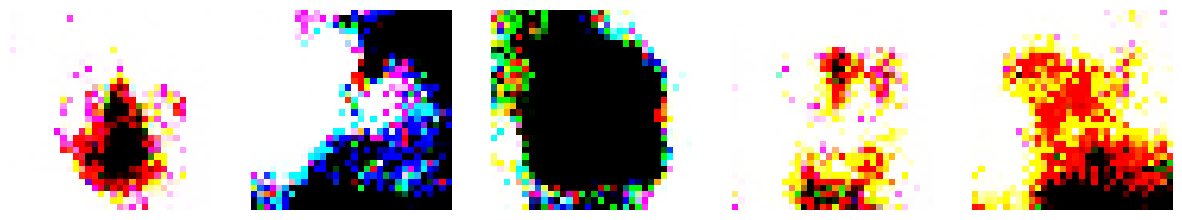

 50%|█████████████████                 | 50/100 [04:08<04:11,  5.02s/it, generator loss:=2.85, discriminator loss:=0.25]

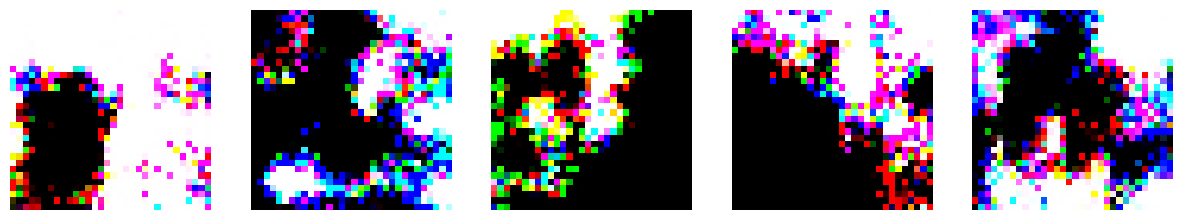

 60%|███████████████████▊             | 60/100 [04:57<03:20,  5.00s/it, generator loss:=3.16, discriminator loss:=0.227]

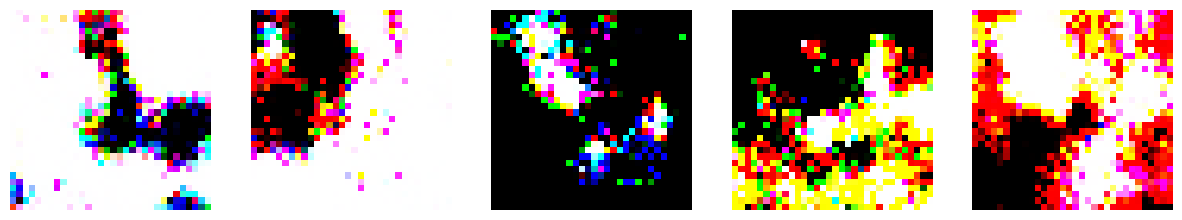

 70%|███████████████████████          | 70/100 [05:47<02:29,  4.98s/it, generator loss:=3.26, discriminator loss:=0.235]

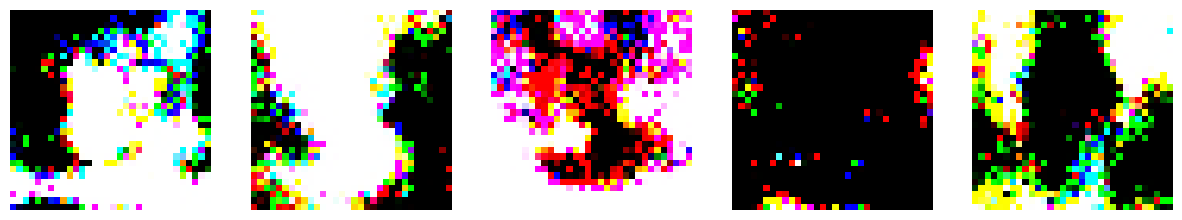

 80%|██████████████████████████▍      | 80/100 [06:37<01:38,  4.91s/it, generator loss:=3.58, discriminator loss:=0.224]

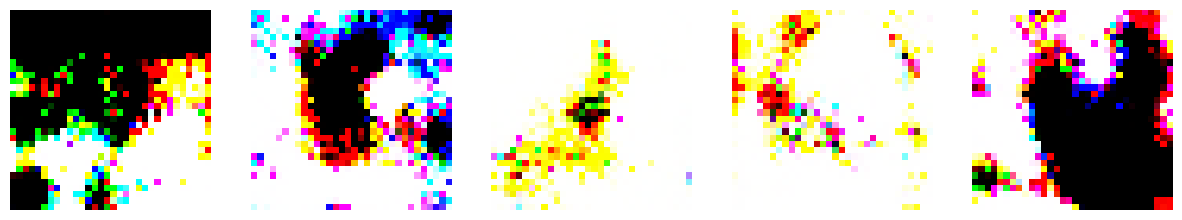

 90%|█████████████████████████████▋   | 90/100 [07:27<00:49,  4.93s/it, generator loss:=3.68, discriminator loss:=0.241]

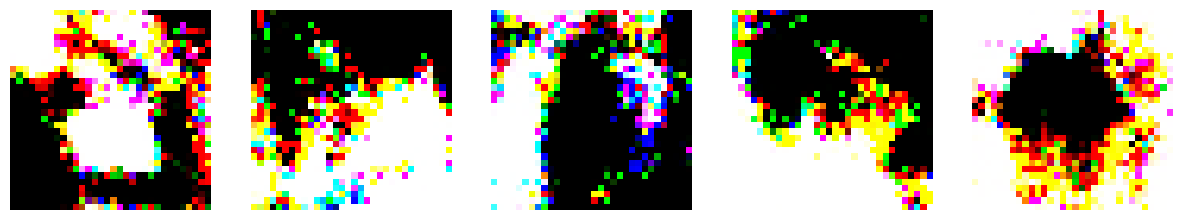

 99%|████████████████████████████████▋| 99/100 [08:11<00:04,  4.98s/it, generator loss:=3.66, discriminator loss:=0.222]

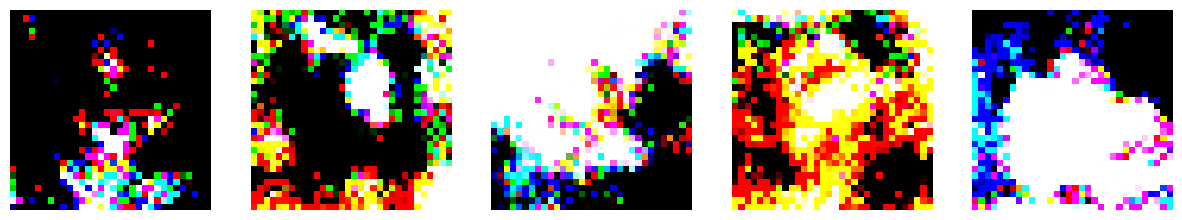

100%|████████████████████████████████| 100/100 [08:16<00:00,  4.97s/it, generator loss:=3.67, discriminator loss:=0.211]


In [14]:
train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device)

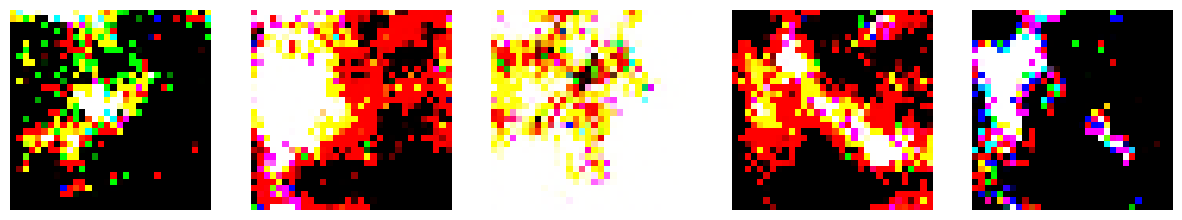

In [15]:
generator.eval()
plotn(5, generator, device)

# DC GAN Implementation

In [16]:
train_size = 1.0
lr = 2e-4
weight_decay = 8e-9
beta1 = 0.5
beta2 = 0.999

In [17]:
class KeiDCGenerator(nn.Module):
    def __init__(self):
        super().__init__()      
        self.conv1 = nn.ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, input):
        # [1, 100, 1, 1]
        hidden1 = self.relu(self.bn1(self.conv1(input)))
        # [1, 1024, 2, 2]
        hidden2 = self.relu(self.bn2(self.conv2(hidden1)))
        # [1, 512, 4, 4]
        hidden3 = self.relu(self.bn3(self.conv3(hidden2)))
        # [1, 256, 8, 8]
        hidden4 = self.relu(self.bn4(self.conv4(hidden3)))
        # [1, 128, 16, 16]
        generated = self.tanh(self.conv5(hidden4))
        # [1, 3, 32, 32]
        return generated

In [18]:
class KeiDCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0), bias=False)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        # [1, 3, 32, 32]
        hidden1 = self.leaky_relu(self.conv1(input))
        # [1, 64, 16, 16]
        hidden2 = self.leaky_relu(self.bn2(self.conv2(hidden1)))
        # [1, 128, 8, 8]
        # [1, 128, 8, 8]
        hidden3 = self.leaky_relu(self.bn3(self.conv3(hidden2)))
        # [1, 256, 4, 4]
        # [1, 256, 4, 4]
        hidden4 = self.leaky_relu(self.bn4(self.conv4(hidden3)))
        # [1, 512, 2, 2]
        # [1, 512, 2, 2]      
        classified = self.sigmoid(self.conv5(hidden4)).view(input.shape[0], -1)
        # [1, 1, 1, 1]
        # [1, 1]
        return classified

In [19]:
adv_generator = KeiDCGenerator().to(device)
adv_generator.apply(weights_init)
adv_discriminator = KeiDCDiscriminator().to(device)
adv_discriminator.apply(weights_init)
print(summary(adv_generator,input_size=(1,100,1,1)))
print(summary(adv_discriminator,input_size=(64,3,32,32)))

Layer (type:depth-idx)                   Output Shape              Param #
KeiDCGenerator                           [1, 3, 32, 32]            --
├─ConvTranspose2d: 1-1                   [1, 1024, 2, 2]           1,638,400
├─BatchNorm2d: 1-2                       [1, 1024, 2, 2]           2,048
├─ReLU: 1-3                              [1, 1024, 2, 2]           --
├─ConvTranspose2d: 1-4                   [1, 512, 4, 4]            8,388,608
├─BatchNorm2d: 1-5                       [1, 512, 4, 4]            1,024
├─ReLU: 1-6                              [1, 512, 4, 4]            --
├─ConvTranspose2d: 1-7                   [1, 256, 8, 8]            2,097,152
├─BatchNorm2d: 1-8                       [1, 256, 8, 8]            512
├─ReLU: 1-9                              [1, 256, 8, 8]            --
├─ConvTranspose2d: 1-10                  [1, 128, 16, 16]          524,288
├─BatchNorm2d: 1-11                      [1, 128, 16, 16]          256
├─ReLU: 1-12                             [1, 128, 1

In [20]:
def dcplotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100, 1, 1))).to(device)
    imgs = generator(noise).detach().cpu()
    
    # Rescale from [-1, 1] to [0, 1]
    imgs = (imgs + 1) / 2
    fig, ax = plt.subplots(1, n, figsize=(n * 3, 3))
    for i, im in enumerate(imgs):
        # print(im.shape)
        # print(im[0])
        ax[i].imshow(np.transpose(im.numpy(), (1, 2, 0)))  # Convert from CHW to HWC format
        ax[i].axis('off')
    plt.show()

In [21]:
def train_dcgan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]
    
    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]
    
    gen.train()
    disc.train()

    for epoch in tqdm_iter:
        train_gen_loss = 0.0
        train_disc_loss = 0.0
        
        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)
            imgs = 2.0 * imgs - 1.0

            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100, 1, 1))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)
            # print(imgs.shape[1])
            generated = gen(noise)
            disc_preds = disc(generated)

            # print(f"Disc_preds: {disc_preds}\nReal: {real_labels}")
            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.zero_grad()
            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            dcplotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [22]:
optimizer_generator = optim.Adam(adv_generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(adv_discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()
adv_models = (adv_generator, adv_discriminator)
adv_optimizers = (optimizer_generator, optimizer_discriminator)

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

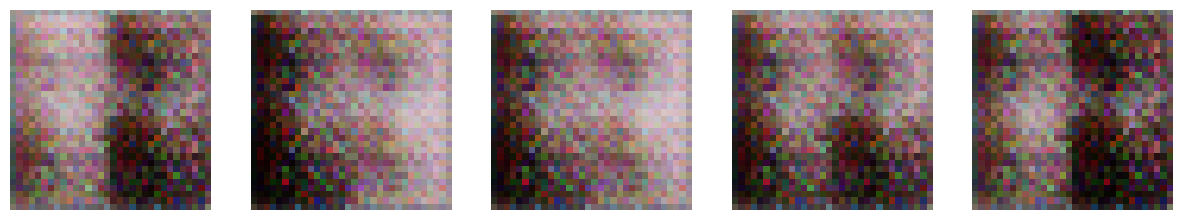

 10%|███▎                             | 10/100 [01:40<15:06, 10.07s/it, generator loss:=1.33, discriminator loss:=0.506]

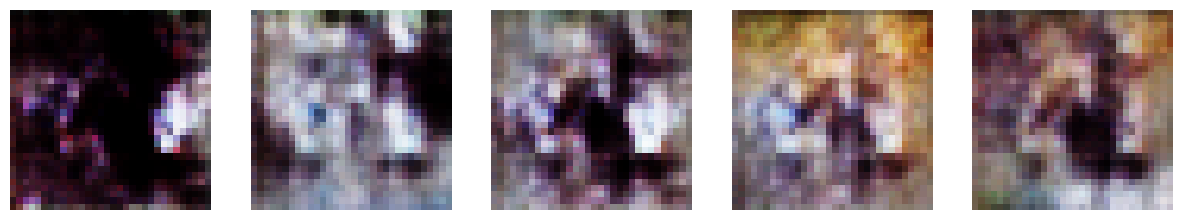

 20%|██████▌                          | 20/100 [03:21<13:24, 10.05s/it, generator loss:=1.62, discriminator loss:=0.434]

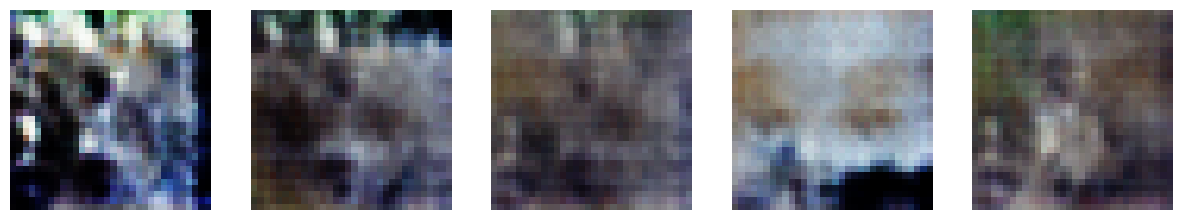

 30%|█████████▉                       | 30/100 [05:02<11:44, 10.06s/it, generator loss:=2.24, discriminator loss:=0.345]

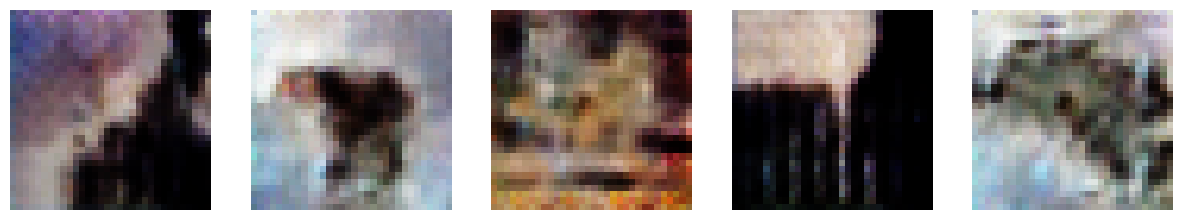

 40%|█████████████▏                   | 40/100 [06:42<10:02, 10.04s/it, generator loss:=2.48, discriminator loss:=0.306]

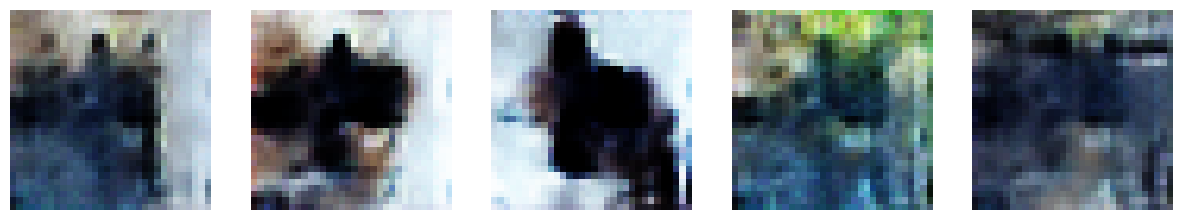

 50%|████████████████▌                | 50/100 [08:23<08:22, 10.06s/it, generator loss:=3.07, discriminator loss:=0.246]

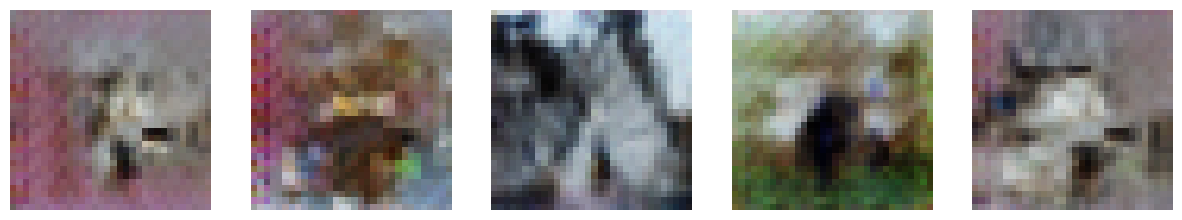

 60%|███████████████████▊             | 60/100 [10:04<06:42, 10.05s/it, generator loss:=3.71, discriminator loss:=0.178]

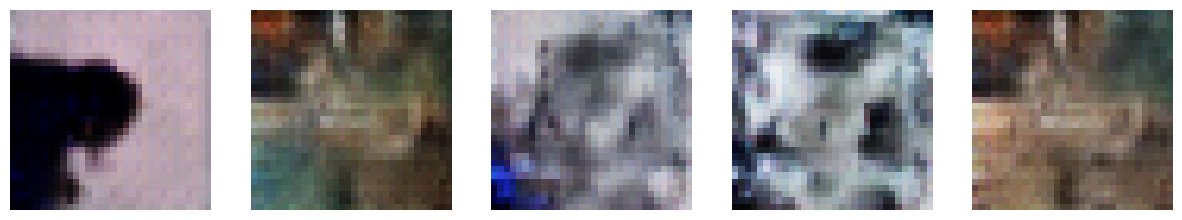

 70%|███████████████████████          | 70/100 [11:44<05:01, 10.04s/it, generator loss:=3.85, discriminator loss:=0.201]

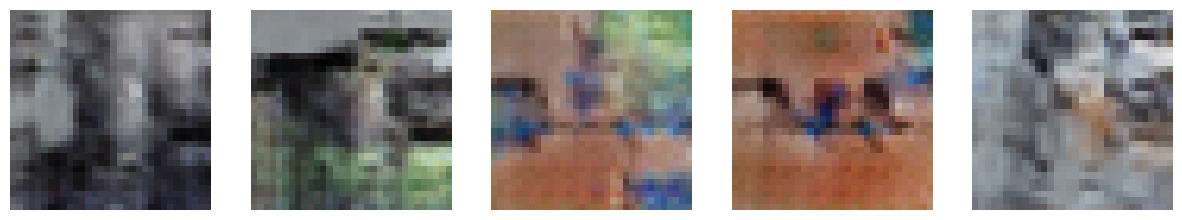

 80%|██████████████████████████▍      | 80/100 [13:25<03:20, 10.04s/it, generator loss:=3.18, discriminator loss:=0.277]

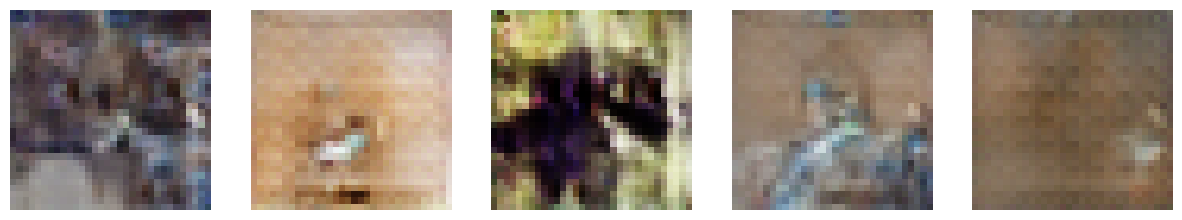

 90%|███████████████████████████████▌   | 90/100 [15:06<01:40, 10.05s/it, generator loss:=3.62, discriminator loss:=0.2]

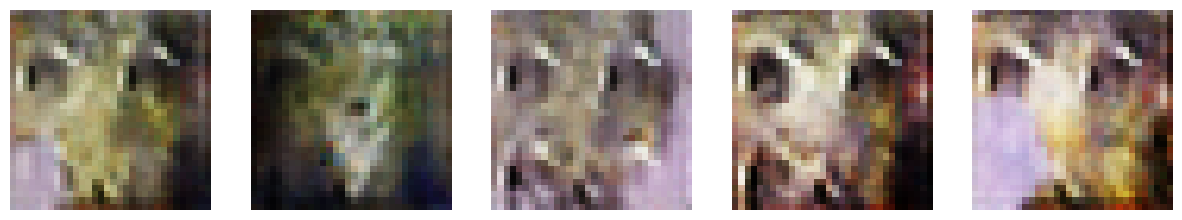

 99%|████████████████████████████████▋| 99/100 [16:36<00:10, 10.05s/it, generator loss:=3.61, discriminator loss:=0.205]

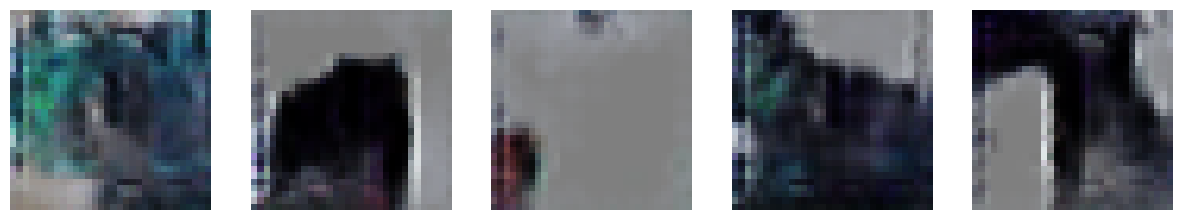

100%|████████████████████████████████| 100/100 [16:47<00:00, 10.07s/it, generator loss:=3.96, discriminator loss:=0.186]


In [23]:
train_dcgan(dataloaders, adv_models, adv_optimizers, loss_fn, epochs, plot_every, device)

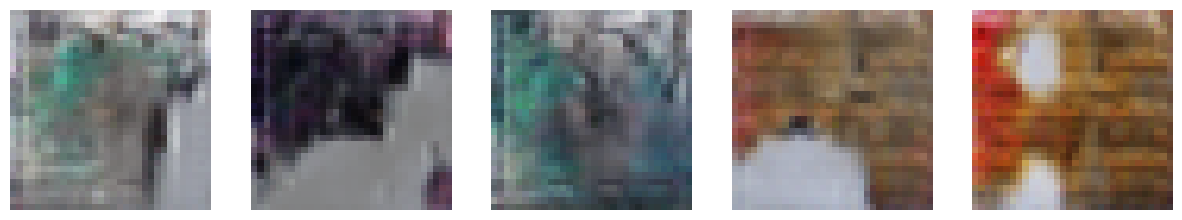

In [24]:
adv_generator.eval()
dcplotn(5, adv_generator, device)

## Updating training function to allow for better generator training

In [29]:
train_size = 1.0
lr = 0.005
weight_decay = 8e-9
beta1 = 0.5
beta2 = 0.999

In [30]:
def upd_train_dcgan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device, gen_updates_per_disc=2):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]
    
    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]
    
    gen.train()
    disc.train()

    for epoch in tqdm_iter:
        train_gen_loss = 0.0
        train_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)
            imgs = 2.0 * imgs - 1.0

            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)

            for _ in range(gen_updates_per_disc):
                gen.zero_grad()
                noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100, 1, 1))).to(device)
                generated = gen(noise)
                disc_preds = disc(generated)
                g_loss = loss_fn(disc_preds, real_labels)
                g_loss.backward()
                optim_gen.step()
                train_gen_loss += g_loss.item()

            disc.zero_grad()
            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()
            train_disc_loss += d_loss.item()

        train_gen_loss /= (len(train_dataloader) * gen_updates_per_disc)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            dcplotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [31]:
upd_adv_generator = KeiDCGenerator().to(device)
upd_adv_generator.apply(weights_init)
upd_adv_discriminator = KeiDCDiscriminator().to(device)
upd_adv_discriminator.apply(weights_init)
optimizer_upd_generator = optim.Adam(upd_adv_generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_upd_discriminator = optim.Adam(upd_adv_discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()
upd_adv_models = (upd_adv_generator, upd_adv_discriminator)
upd_adv_optimizers = (optimizer_upd_generator, optimizer_upd_discriminator)

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

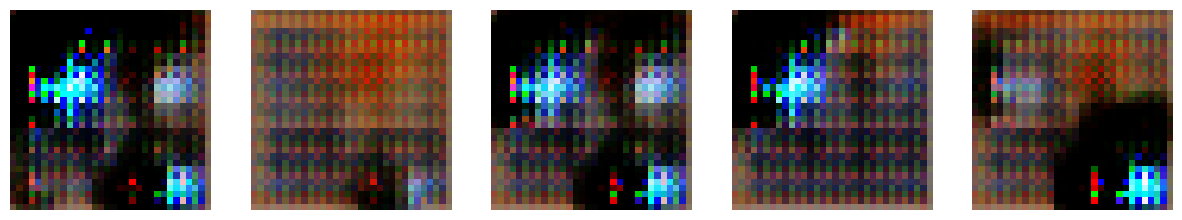

 10%|███▎                             | 10/100 [02:48<25:17, 16.86s/it, generator loss:=1.36, discriminator loss:=0.571]

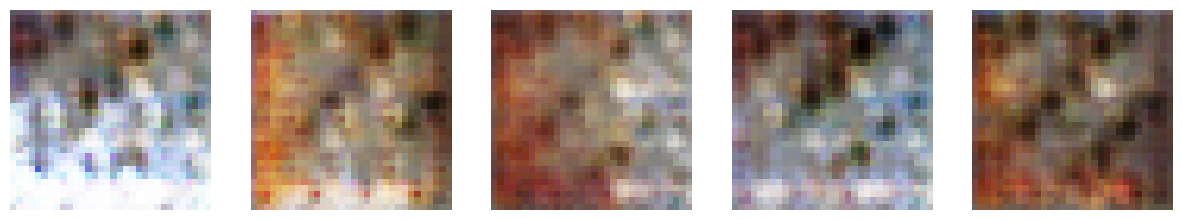

 20%|██████▌                          | 20/100 [05:37<22:30, 16.88s/it, generator loss:=1.12, discriminator loss:=0.626]

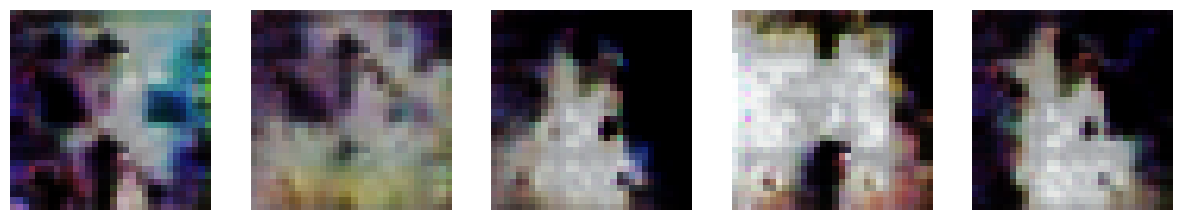

 30%|██████████▊                         | 30/100 [08:26<19:40, 16.86s/it, generator loss:=3, discriminator loss:=0.355]

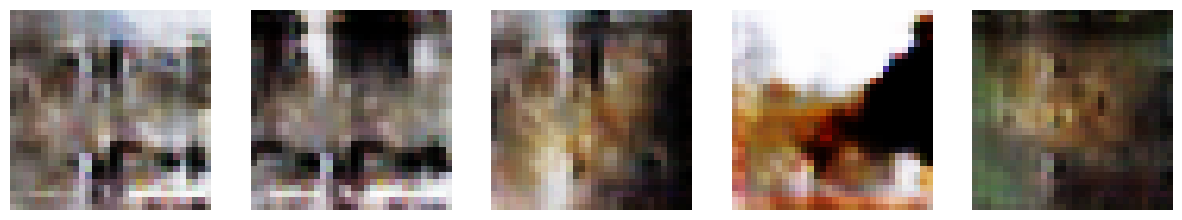

 36%|███████████▉                     | 36/100 [10:08<18:01, 16.90s/it, generator loss:=3.46, discriminator loss:=0.319]

In [ ]:
upd_train_dcgan(dataloaders, upd_adv_models, upd_adv_optimizers, loss_fn, epochs, plot_every, device)

In [ ]:
upd_adv_generator.eval()
dcplotn(5, upd_adv_generator, device)